# Predicting In-Game Win Probability

The purpose of this model is to predict the in-game win probability for the home team, based on the current game state. The model takes the goal and shot totals for each team, as well as the current game time. It outputs an estimated probability of the home team winning. Team strength and style effects will be included later. 

These results will be used as an input to the Player Impact model, where player contributions occurring when the game is still in the balance (i.e. the in-game win probability is closer to 50%) are weighted more heavily than contributions when the outcome of a game is more certain. 

The model is kept intentionally simple, ignoring game events such as hits and penalties. However, the requirement of an output probability limits the selection of possible model classes. In this investigation, three classes are trained and compared:
1. Logistic Regression
2. Naive Bayes
3. Neural Network

It's a fairly simply problem, so all three models performed similarly. They all scored better than the trivial fit (shown below) and are relatively well calibrated. However, the neural network is the only one that takes game time into account, and it is the best calibrated. Additionally, this is a relatively simple model, requiring little explanation, so interpretability is not a concern. Therefore, the neural network is the model chosen to move forward with. For the working version, an ensemble of models will be trained and used to predict the in-game win probability, as this smooths out initialization and training differences.

### TODO
- Add neural network model comparison (with shot differential removed)
- Shootout games are surprisingly 10% of data. Find a way to use this. Removing it seems like it could bias the outcome.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from scipy.stats import kurtosis
from common import create_db_connection, select_table
from nhl_api.ref_common import game_time_to_sec
from models.common_torch import Regression_NN, CustomDataset, train_loop


In [2]:
# Create the database connection
connection = create_db_connection('postgres', 'marshineer', 'localhost', '5432',
                                  'password')


## Preprocessing and Model Inputs

There is very little preprocessing required, as much of this has been done previously. Misses and blocked shots are ignored, as these are thought to have less of an impact on the game status. Additionally, empty net goals are removed because they are more opportunity based than skill based, and the goal of this model is ultimately to help predict player impact. Overtime events are also removed, as this is again opportunity based, and creates an odd game time distribution that I am worried will bias the model.

The model inputs are reduced to three features:
1. Score Difference = Home Score - Away Score
2. Shot Difference = Home Shots - Away Shots
3. Game Time (in seconds)

The target variable is a binary variable ($y \in [0, 1]$) indicating whether the home team wins.

In [3]:
# Load the game and shot data
shots_df = select_table(connection, 'shots')
shots_df = shots_df.loc[shots_df.shot_result.isin(['GOAL', 'SHOT'])]
games_df = select_table(connection, 'games')
games_list = games_df.to_dict('records')
games = {game_x['game_id']: game_x for game_x in games_list}
print(shots_df.columns.tolist())


['game_id', 'shot_id', 'shooter_id', 'shot_type', 'shot_result', 'period', 'period_time', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'x_coord', 'y_coord', 'net_distance', 'net_angle', 'rebound_shot', 'last_event_type', 'time_since_last', 'last_x_coord', 'last_y_coord', 'delta_y', 'angle_change', 'play_ends', 'puck_frozen', 'goal', 'missed', 'blocked', 'empty_net', 'shooter_home', 'shooter_hand', 'off_wing_shot', 'players_home', 'players_away']


In [4]:
# Remove empty net goals
print('Removed:')
print(f'Number of goals on empty nets = {len(shots_df[shots_df.empty_net == True])} '
      f'({100 * len(shots_df[shots_df.empty_net == True]) / len(shots_df[shots_df.shot_result == "GOAL"]):4.2f}% of all goals)')
shots_df.drop(shots_df[shots_df.empty_net == True].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove overtime shots
print(f'Number of shots in overtime = {len(shots_df[shots_df.period > 3])} '
      f'({100 * len(shots_df[shots_df.period > 3]) / len(shots_df):4.2f}% of all shots)')
shots_df.drop(shots_df[shots_df.period > 3].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove shootout games
shootout_games = games_df.loc[games_df.home_score == games_df.away_score]
print(f'Number of shootout games = {len(shootout_games)} '
      f'({100 * len(shootout_games) / len(games_df):4.2f}% of all games)')
shots_df.drop(shots_df[shots_df.game_id.isin(shootout_games.game_id.tolist())].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Convert the shots to a list
shots_list = shots_df.to_dict('records')


Removed:
Number of goals on empty nets = 3880 (4.64% of all goals)
Number of shots in overtime = 17182 (1.89% of all shots)
Number of shootout games = 1424 (9.52% of all games)


In [5]:
# Define the input features and target variable
# data_cols = ['home_score', 'away_score', 'home_shots', 'away_shots',
#              'game_time', 'home_win']  # Add team strengths later
data_cols = ['goal_diff', 'shot_diff', 'game_time', 'home_win']  # Add team strengths later
this_game_id = None
home_shots = None
away_shots = None
home_win = None
data_list = []
n_games = 0
n_home_wins = 0
for shot in shots_list:
    game_id = shot['game_id']
    # if games[game_id]['home_score'] == games[game_id]['away_score']:
    #     continue
    if this_game_id != game_id:
        home_shots = 1
        away_shots = 1
        this_game_id = game_id
        home_win = 1 if games[game_id]['home_win'] else 0
        if home_win == 1:
            n_home_wins += 1
        n_games += 1
        # data_list.append([0, 0, 0, home_win])
    else:
        if shot['shooter_home']:
            home_shots += 1
        else:
            away_shots += 1
    period = shot['period']
    period_time = shot['period_time']
    game_time = (period - 1) * 20 * 60 + game_time_to_sec(period_time)
    # game_time = 3600 - ((period - 1) * 20 * 60 + game_time_to_sec(period_time))
    home_score = shot['home_score']
    away_score = shot['away_score']
    data_list.append([home_score - away_score, home_shots - away_shots,
                      game_time, home_win])
    
    # if np.random.choice(10, 1) == 0:
    #     # data_list.append([home_score, away_score, home_shots, away_shots,
    #     #                   game_time, home_win])
    #     data_list.append([home_score - away_score, home_shots - away_shots,
    #                       game_time, home_win])
    # # if shot['shot_result'] == 'GOAL':
    # #     # home_score = shot['home_score']
    # #     # away_score = shot['away_score']
    # #     # data_list.append([home_score, away_score, home_shots, away_shots,
    # #     #                   game_time, home_win])
    # #     data_list.append([home_score - away_score, home_shots - away_shots,
    # #                       game_time, home_win])
    # #     # if shot['shooter_home']:
    # #     #     # data_list.append([home_score - 1, away_score, home_shots, away_shots,
    # #     #     #                   game_time, home_win])
    # #     #     data_list.append([(home_score - 1) - away_score, home_shots - away_shots,
    # #     #                       game_time, home_win])
    # #     # else:
    # #     #     # data_list.append([home_score, away_score - 1, home_shots, away_shots,
    # #     #     #                   game_time, home_win])
    # #     #     data_list.append([home_score - (away_score - 1), home_shots - away_shots,
    # #     #                       game_time, home_win])
data_df = pd.DataFrame(data_list, columns=data_cols)


## Input Visualization

The plots below were created as a sanity check, and to determine what preprocessing needed to be done. This contributed to deciding to remove the overtime shots and empty net goals. Additionally, the following observations are noted.
- The shot events are distributed approximated evenly across game times
- Both shot and goal differentials have a kurtosis > 0 (the peaky shape), meaning there is a slightly greater number of outliers compared to a normal distribution
- There are no strong monotonic correlations between the features and target (goal differential shows a moderate correlation)
- The proportion of shot events corresponding to home wins is approximately equal to the actual proportion of home wins

These results generally match what I would expect, although I would have thought the shot and goal differentials would follow almost a pefectly normal distribution. 

Since the goal differential is the only feature correlated with the target variable, it may be possible to simplify the model by training on this single feature. This will be invesitgated later. 

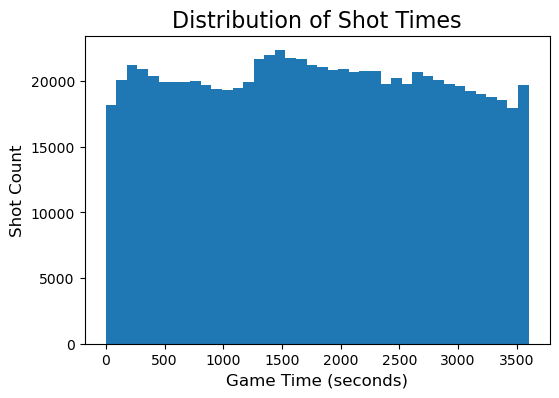

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(data_df.game_time, bins=40)
ax.set_title('Distribution of Shot Times', fontsize=16)
ax.set_xlabel('Game Time (seconds)', fontsize=12)
ax.set_ylabel('Shot Count', fontsize=12);


The kurtosis of goal_diff is 1.23
The kurtosis of goal_diff is 1.18


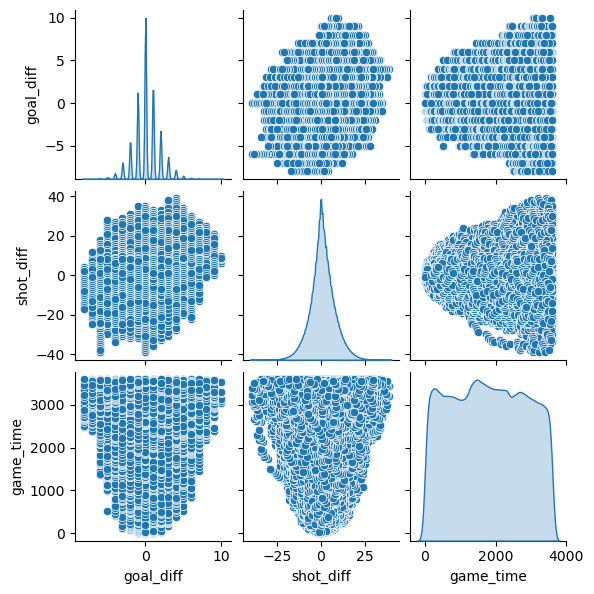

In [7]:
# Display the feature relationships in scatter plots
sns.pairplot(data_df.iloc[:, :-1], height=2, diag_kind='kde')
print(f'The kurtosis of goal_diff is {kurtosis(data_df.goal_diff, bias=False):3.2f}')
print(f'The kurtosis of goal_diff is {kurtosis(data_df.shot_diff, bias=False):3.2f}')


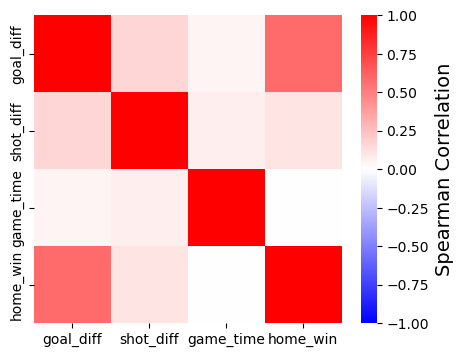

In [8]:
# Plot Feature Correlations
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.heatmap(data_df.corr(method='spearman'), cmap='bwr', vmin=-1, vmax=1, square=True, ax=ax)
ax.collections[0].colorbar.set_label('Spearman Correlation', fontsize=14)


Home team winning corresponds to 54.83% of data points
Home team wins 54.48% of games


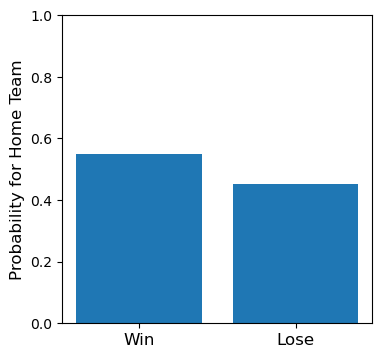

In [9]:
# Plot the distribution of home wins
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
win_mask = data_df.home_win == 1
targets = [len(data_df.home_win.loc[win_mask]) / len(data_df),
           len(data_df.home_win.loc[~win_mask]) / len(data_df)]
ax.bar([0.5, 1.5], targets)
ax.set_ylabel('Probability for Home Team', fontsize=12)
ax.set_ylim([0, 1])
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['Win', 'Lose'], fontsize=12)
# plt.show()

# Calculate the "trivial" logloss
p_home_win = len(data_df.home_win.loc[win_mask]) / len(data_df)
trivial_logloss = -(p_home_win * np.log(p_home_win) + (1 - p_home_win) * np.log(1 - p_home_win))
print(f'Home team winning corresponds to {100 * p_home_win:4.2f}% of data points')
print(f'Home team wins {100 * (n_home_wins / n_games):4.2f}% of games')
# print(len(data_df.home_win.loc[win_mask]))
# print(len(data_df.home_win.loc[~win_mask]))


## Model Selection

Firstly, the data is split into training and test sets, as well as being normalized to the range [0, 1]. Following best practices, the test data is normalized using the fit of the training data. Note that since the data set is quite large, random shuffling results in approximately similar class distributions in both the training and test sets.

Three model classes are trained and compared.
1. Logistic Regressor
2. Naive Bayes Classifier
3. Neural Network

Sklearn has a built-in logistic regressor and naive Bayes classifier. These include an attribute that predicts the probability of a class directly. The neural network is programmed using PyTorch, with a logit function applied to the output to transform the predictions into probabilities.

Although the data is not entirely Gaussian, the GaussianNB model seemed the best fit for the problem. There are few parameters to tune for this model, so the base version was used. The LogisticRegression model has a greater selection of model parameters, but it trains quickly, so a grid search was done to find the best combination of regularization and solver. The cross-validation splits are done using a stratified k-fold, to ensure the balance of target classes remains consistent during the parameter search. 

The neural network is a simple, 3-layer network. Multiple learning rates and, batch sizes, and optimizers (stochastic gradient descent (SGD) and Adam) were tested. None of the selections had a significant impact on the performance, but the Adam solver trained much faster than SGD. Therefore, the Adam solver with a learning rate of $10^{2}$ was used.


In [10]:
# Split the data into training and test sets
X_pd, y_pd = data_df.iloc[:, :-1].values, data_df.iloc[:, -1].values
tmp_split = train_test_split(X_pd, y_pd, test_size=0.25, random_state=66)
X_train, X_test, y_train, y_test = tmp_split

# Scale the data
x_scaler = MinMaxScaler()
X_train_norm = x_scaler.fit_transform(X_train)
X_test_norm = x_scaler.transform(X_test)


In [11]:
# Logistic regression model
# https://medium.com/towards-data-science/assumptions-of-logistic-regression-clearly-explained-44d85a22b290
d_logr = {'name': 'Logistic Regression',
          'model': LogisticRegression(max_iter=200, penalty='l2', class_weight='balanced'),
          'params': {'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
                     'C': [1, 10, 50, 100, 200, 500, 1000]}}


In [12]:
# Train the model using k-fold cross-validation and a random parameter search
t_start = time()
cv_split = StratifiedKFold(n_splits=10)
param_search = GridSearchCV(d_logr['model'], d_logr['params'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search.fit(X_train_norm, y_train)
d_logr['search_result'] = param_search
d_logr['model'] = param_search.best_estimator_
d_logr['train_loss'] = -param_search.best_score_
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the logistic regressor')


Took 0:01:28.314468 to train the logistic regressor


Trivial logloss for this problem: 0.688
Training logloss on Logit model: 0.491
Test logloss on Logit model: 0.491
Test accuracy on Logit model: 72.50%


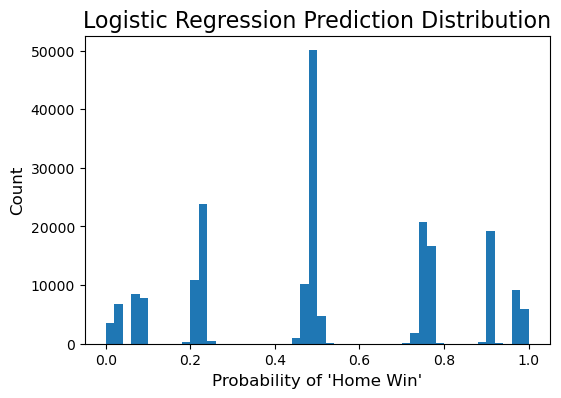

In [13]:
# Make predictions on the test set
d_logr['y_pred'] = d_logr['model'].predict_proba(X_test_norm)[:, 1]
# print(d_logr['y_pred'])
d_logr['test_loss'] = log_loss(y_test, d_logr['y_pred'])
pred_classes = np.round(d_logr['y_pred'], 0)
d_logr['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_logr['y_pred'], bins=50);
ax.set_title('Logistic Regression Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Home Win'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {trivial_logloss:4.3f}")
print(f"Training logloss on Logit model: {d_logr['train_loss']:4.3f}")
print(f"Test logloss on Logit model: {d_logr['test_loss']:4.3f}")
print(f"Test accuracy on Logit model: {d_logr['test_acc']:4.2f}%")


In [14]:
# Naive Bayes model
# https://scikit-learn.org/stable/modules/naive_bayes.html#
t_start = time()
d_nbayes = {'name': 'Naive Bayes',
            'model': GaussianNB()}
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the naive bayes model')


Took 0:00:00.000060 to train the naive bayes model


Trivial logloss for this problem: 0.688
Training logloss on NB model: 0.493
Test logloss on NB model: 0.493
Test accuracy on NB model: 74.35%


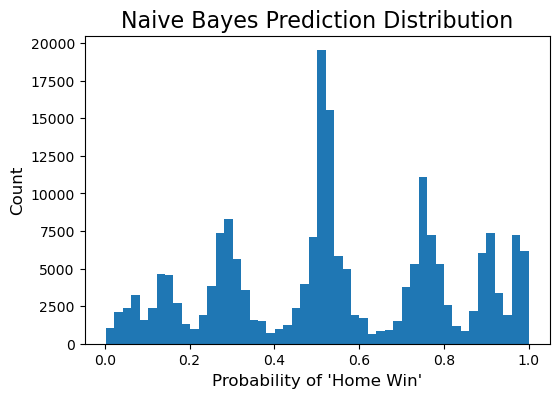

In [15]:
# Train and test the model
d_nbayes['model'].fit(X_train_norm, y_train)
d_nbayes['train_loss'] = log_loss(y_train,
                                  d_nbayes['model'].predict_proba(X_train_norm)[:, 1])
d_nbayes['y_pred'] = d_nbayes['model'].predict_proba(X_test_norm)[:, 1]
d_nbayes['test_loss'] = log_loss(y_test, d_nbayes['y_pred'])
pred_classes = np.round(d_nbayes['y_pred'], 0)
d_nbayes['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nbayes['y_pred'], bins=50);
ax.set_title('Naive Bayes Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Home Win'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {trivial_logloss:4.3f}")
print(f"Training logloss on NB model: {d_nbayes['train_loss']:4.3f}")
print(f"Test logloss on NB model: {d_nbayes['test_loss']:4.3f}")
print(f"Test accuracy on NB model: {d_nbayes['test_acc']:4.2f}%")


In [16]:
import torch.nn as nn
from torch import optim, Tensor, sigmoid
from torch.utils.data import DataLoader


In [17]:
# Define hyperparameters
learning_rate = 1e-4
batch_size = 512
n_epochs = 50
loss_fn = nn.BCEWithLogitsLoss()


In [18]:
# Define the training and test data loaders
train_data = CustomDataset(X_train_norm, y_train)
test_data = CustomDataset(X_test_norm, y_test)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize a model and optimizer
d_nn = {'name': 'Neural Network',
        'model': Regression_NN(X_train_norm.shape[-1], 32, 1).to('cpu').float()}
# optimizer = optim.SGD(d_nn['model'].parameters(), lr=learning_rate)
optimizer = optim.Adam(d_nn['model'].parameters(), lr=learning_rate)


Took 0:04:34.903827 to train the model


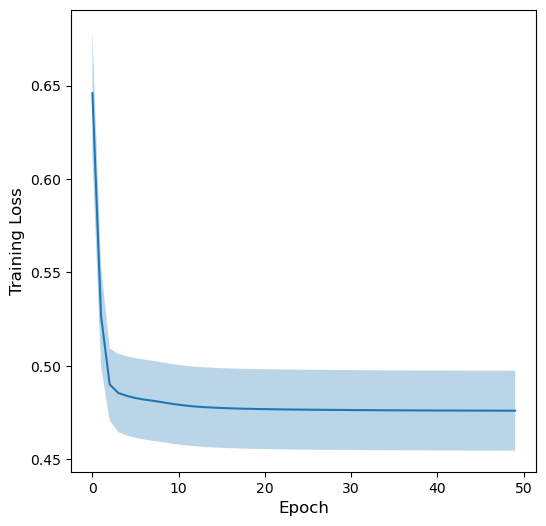

In [19]:
# Train the model
train_loss_avg = np.zeros(n_epochs)
train_loss_std = np.zeros(n_epochs)
t_start = time()
for t in range(n_epochs):
    epoch_loss = train_loop(train_dataloader, d_nn['model'], loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(np.arange(n_epochs), train_loss_avg)
ax.fill_between(np.arange(n_epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the model')
plt.show()


Trivial logloss for this problem: 0.688
Training logloss on NN model: 0.476
Test logloss on NN model: 0.475
Test accuracy on NN model: 74.56%


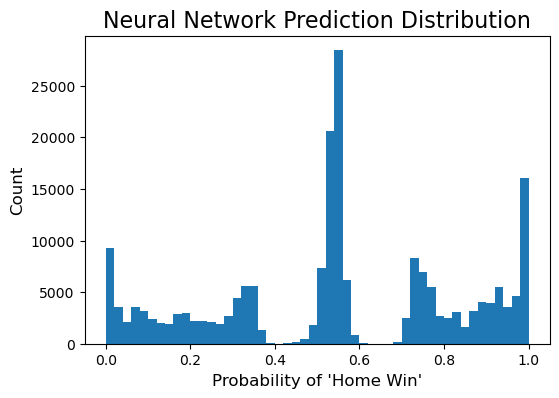

In [20]:
# Test the model
y_pred_train_nn = sigmoid(d_nn['model'](Tensor(X_train_norm))).detach().numpy().squeeze()
d_nn['train_loss'] = log_loss(y_train, y_pred_train_nn)
d_nn['y_pred'] = sigmoid(d_nn['model'](Tensor(X_test_norm))).detach().numpy().squeeze()
d_nn['test_loss'] = log_loss(y_test, d_nn['y_pred'])
print(f"Trivial logloss for this problem: {trivial_logloss:4.3f}")
print(f"Training logloss on NN model: {d_nn['train_loss']:4.3f}")
print(f"Test logloss on NN model: {d_nn['test_loss']:4.3f}")
pred_classes = np.round(d_nn['y_pred'], 0)
d_nn['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size
print(f"Test accuracy on NN model: {d_nn['test_acc']:4.2f}%")

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nn['y_pred'], bins=50)
ax.set_title('Neural Network Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Home Win'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


## Model Comparison

The three models are compared by the following methods:
- Logloss performance
- Accuracy
- Prediction calibration
- Confusion matrices
- Qualitative assessment

### Logloss performance: 
This is the most common evaluator for binary class probability predictions. There are numerous resources online describing the utility of logloss for this application, so I won't go into it here. Each of the models performed similarly, and they all performed better than the trivial loss of $L(p)=0.688$. Note: the trivial loss is calculated as $p \cdot ln(p) + (1-p)\cdot ln(1-p)$, where N is the number of target classes and p is the probability of the target class equalling either 0 or 1.

### Accuracy:
Since the dataset is well balanced (approximately 55-45), accuracy is a reasonable metric to use. If the classes were more imbalanced, the F1 score could be calculated. Again, the models all performed similarly, at an accuracy just below 75%.

### Prediction calibration:
This metric is described in further detail in sklearn's [documentation](https://scikit-learn.org/stable/modules/calibration.html). The main idea is that data points classified with a certain probability, should be correctly classified at the rate of the probability. For example, if the model predicts 100 data points as class 1, with a probability of 80%, then 80 of those points should actually belong to class 1, while the other 20 should belong to class 0. These proportions will hold for all probabilities in a well calibrated model. The idea behind this is intuitive. Data points that are difficult to classify (i.e. with a prediction probability near 50%) should be incorrectly classified less often than points given a 95% probability.

In practice, this is calculated statistically, by binning predictions and comparing the bin probabilities with the true fraction of classes. Note that if a bin includes zero data points, the fraction of correctly classified points will evaluate to nan. This is the cause for the warnings in this section.

This can be assessed qualitatively, with a calibration curve. As described above, an ideal model will lie along the diagonal line. Sub-optimal models will deviate from this diagonal. This deviation is a residual, so I decided to quantify the performance using the root mean squared error (RMSE). I noticed that many of the deviations coincided with bins containing few samples, so I weighted by bin counts to account for sample size. This provided a quantitative measure by which to compare the models' calibration.

### Confusion matrices:
There is not much to separate the models here, but it is interesting to note that both the naive Bayes and neural network models tend to overpredict home wins, while the logistic regressor overpredicts home losses. This imbalance is something to address in future versions.

### Qualitative assessment:
This is simply a check to determine whether the model performs as one would expect for a given game. Ideally, the model will demonstrate three important characteristics.
1. Give an initial prediction of close to 50% (likely skewed by the bias toward home wins in the data)
2. Significant jumps in probability when goals are scored
3. Slowly drift as game time increases (since the losing team is running out of room to tie the game)

As can be seen, all three models exhibit the first two characteristics. However, the drift is relatively choppy and could be a result of shot accumulation for each team, rather than a response to game time. The neural network does seem to do a better job of weighting the late goal differential more heavily than an early goal differential, while the other two models seem to give too much importance to the early game state. 

Overall, all three models appear to respond well to the game state, but there are some details the neural network captures, which are missing from the others.

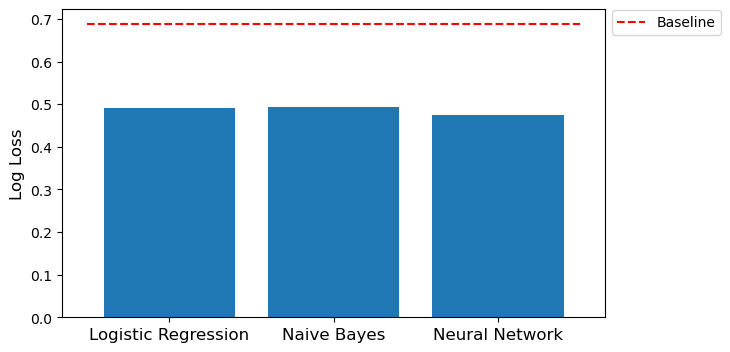

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
model_list = [d_logr, d_nbayes, d_nn]
model_names = [model['name'] for model in model_list]
ax.bar([0.5, 1.5, 2.5], [model['test_loss'] for model in model_list])
# ax.set_title('Model Logloss Comparison', fontsize=16)
ax.set_ylabel('Log Loss', fontsize=12)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(model_names, fontsize=12)
ax.plot(np.arange(0, 4), np.ones(4) * trivial_logloss, 'r--', label='Baseline')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));


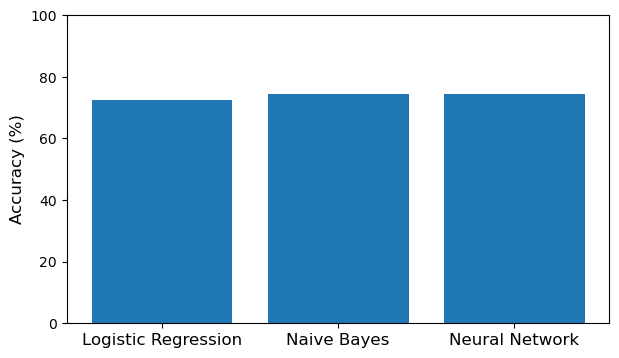

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.bar([0.5, 1.5, 2.5], [model['test_acc'] for model in model_list])
# ax.set_title('Model Accuracy Comparison', fontsize=16)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(model_names, fontsize=12)
ax.set_ylim([0, 100]);


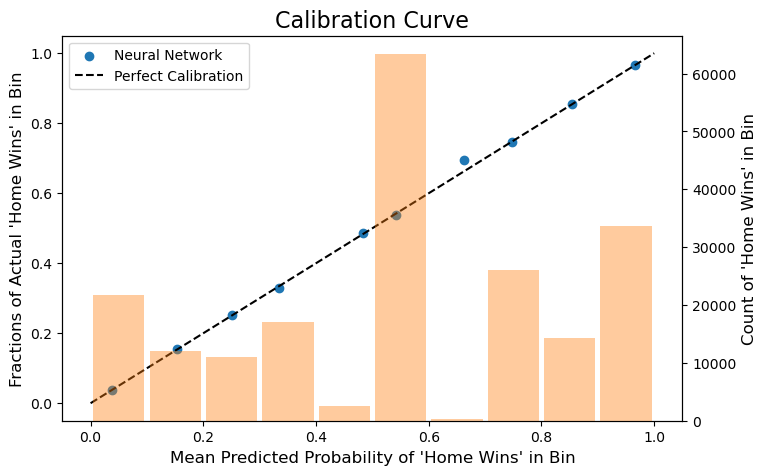

In [23]:
# Check the calibration of each model
# https://scikit-learn.org/stable/modules/calibration.html
counts, bins = np.histogram(d_nn['y_pred'], bins=10)
mean_pred = np.zeros(bins.size - 1)
true_frac = np.zeros(bins.size - 1)
for i in range(bins.size - 1):
    bin_mask = (d_nn['y_pred'] >= bins[i]) & (d_nn['y_pred'] < bins[i + 1])
    y_pred_bin = d_nn['y_pred'][bin_mask]
    mean_pred[i] = np.mean(y_pred_bin)
    y_true_bin = y_test[bin_mask]
    true_frac[i] = (y_true_bin == 1).sum() / y_true_bin.size

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(mean_pred, true_frac, label='Neural Network')
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
ax.set_xlabel("Mean Predicted Probability of 'Home Wins' in Bin", fontsize=12)
ax.set_ylabel("Fractions of Actual 'Home Wins' in Bin", fontsize=12)
ax.set_title('Calibration Curve', fontsize=16)
ax.legend()

ax2 = ax.twinx()
xs = bins[:-1] + np.diff(bins)[0] / 2
ax2.bar(xs, counts, color='C1', width=1 / bins.size, alpha=0.4)
ax2.set_ylabel("Count of 'Home Wins' in Bin", fontsize=12);


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_55514/1708601310.py:15: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size


The calibration RMSE for the Logistic Regression model (weighted by bin counts) is 5.791
The calibration RMSE for the Naive Bayes model (weighted by bin counts) is 4.284
The calibration RMSE for the Neural Network model (weighted by bin counts) is 0.370


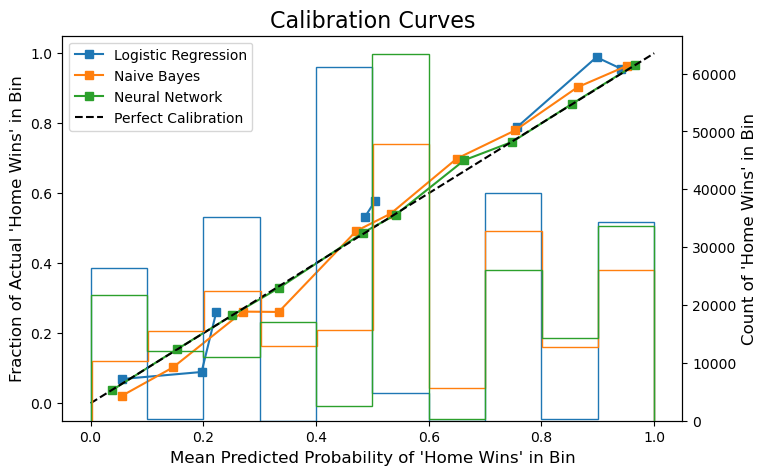

In [24]:
# Check the calibration of each model
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax2 = ax.twinx()
for i, model in enumerate(model_list):
    # Calculate the calibration curve data
    y_pred = model['y_pred']
    counts, bins = np.histogram(y_pred, bins=10)
    mean_pred = np.zeros(bins.size - 1)
    true_frac = np.zeros(bins.size - 1)
    for j in range(bins.size - 1):
        bin_mask = (y_pred >= bins[j]) & (y_pred < bins[j + 1])
        y_pred_bin = y_pred[bin_mask]
        mean_pred[j] = np.mean(y_pred_bin)
        y_true_bin = y_test[bin_mask]
        true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size

    # Plot the calibration curve
    ax.plot(mean_pred, true_frac, c=f'C{i}', marker='s', label=model['name'])

    # Plot the prediction distributions for comparison
    xs = bins[:-1] + np.diff(bins)[0] / 2
    # ax2.bar(xs, counts, color=None, edgecolor=f'C{i}', width=1 / bins.size, alpha=0.2)
    ax2.hist(y_pred, bins=bins, color=f'C{i}', histtype='step')
    
    # Print the RMSE for each calibration curve
    weighted_rmse = np.sqrt(np.nanmean(((mean_pred - true_frac) ** 2) * counts))
    print(f"The calibration RMSE for the {model['name']} model (weighted by bin counts) is {weighted_rmse:4.3f}")
    # rmse = np.sqrt(np.nanmean((mean_pred - true_frac) ** 2))
    # print(f"The RMSE for the {model['name']} model is {rmse:4.3f}")

ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
ax.set_xlabel("Mean Predicted Probability of 'Home Wins' in Bin", fontsize=12)
ax.set_ylabel("Fraction of Actual 'Home Wins' in Bin", fontsize=12)
ax.set_title('Calibration Curves', fontsize=16)
ax.legend()
ax2.set_ylabel("Count of 'Home Wins' in Bin", fontsize=12);


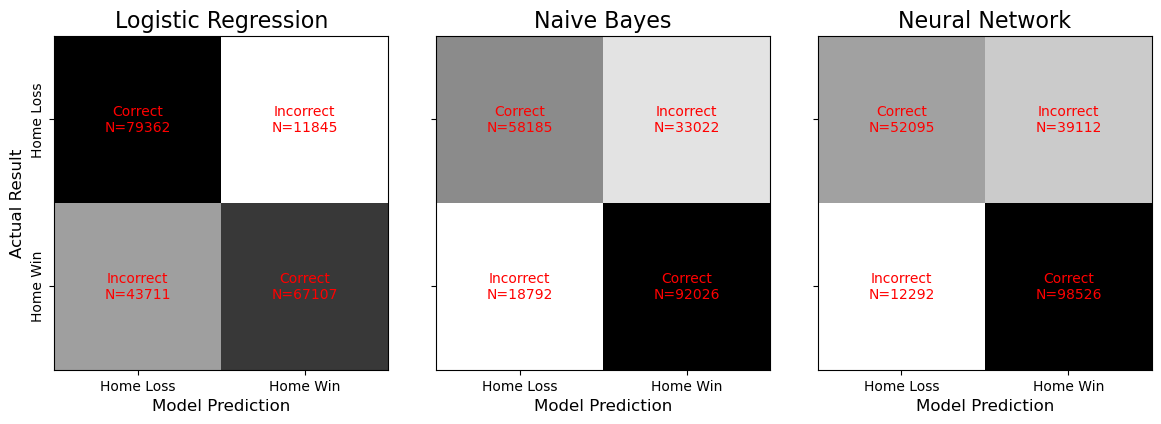

In [25]:
# Plot confusion matrices
fig, axes = plt.subplots(1, len(model_list), figsize=(12, 4), sharey=True)
for i, model in enumerate(model_list):
    conf_mat = confusion_matrix(y_test, np.round(model['y_pred'], 0))
    axes[i].imshow(conf_mat, cmap='Greys')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Home Loss', 'Home Win'])
    axes[i].set_xlabel('Model Prediction', fontsize=12)
    axes[i].set_yticks([0, 1])
    axes[i].set_yticklabels(['Home Loss', 'Home Win'], va='center', rotation='vertical')
    axes[0].set_ylabel('Actual Result', fontsize=12)
    axes[i].text(0, 0, f'Correct\nN={conf_mat[0, 0]}', c='r', ha='center', va='center')
    axes[i].text(1, 0, f'Incorrect\nN={conf_mat[0, 1]}', c='r', ha='center', va='center')
    axes[i].text(0, 1, f'Incorrect\nN={conf_mat[1, 0]}', c='r', ha='center', va='center')
    axes[i].text(1, 1, f'Correct\nN={conf_mat[1, 1]}', c='r', ha='center', va='center')
    axes[i].set_title(model['name'], fontsize=16)
fig.tight_layout();


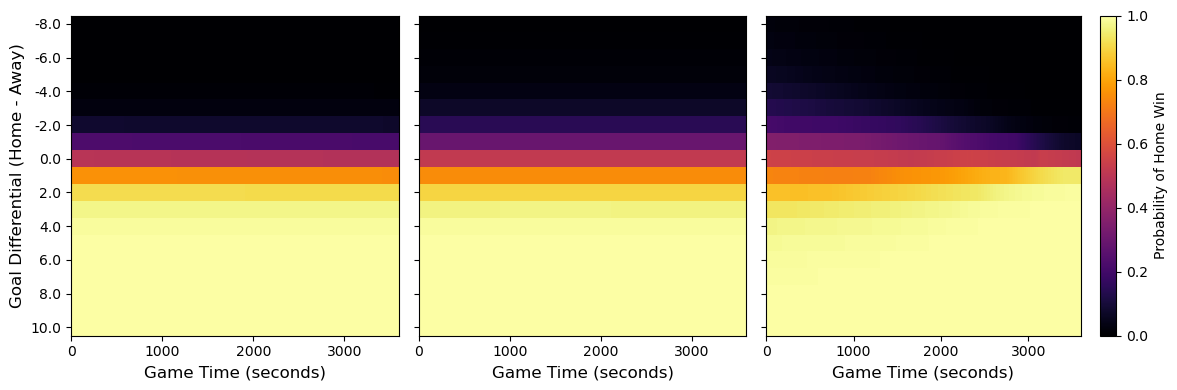

In [26]:
# Calculate the win probability across all game times and goal differentials
goal_diff_range = np.arange(np.floor(data_df.goal_diff.min()), np.ceil(data_df.goal_diff.max() + 1))
game_secs = 20 * 3 * 60
model_probs = np.zeros((len(model_list), goal_diff_range.size, game_secs))
for i, model in enumerate(model_list):
    for j, g_diff in enumerate(goal_diff_range):
        for sec in range(game_secs):
            input_arr = x_scaler.transform(np.array([g_diff, 0, sec]).reshape(1, -1))
            # if sec == 0 and j == 0:
            #     print(input_arr)
            if model['name'] == 'Neural Network':
                model_probs[i, j, sec] = sigmoid(model['model'](Tensor(input_arr))).detach().numpy().squeeze()
            else:
                model_probs[i, j, sec] = model['model'].predict_proba(input_arr).squeeze()[1]

# Plot the distributions
fig, axes = plt.subplots(1, len(model_list), figsize=(12, 4), sharey=True,
                         gridspec_kw={'width_ratios':[1, 1, 1.2]})
# fig, axes = plt.subplots(1, len(model_list) + 1, figsize=(10, 3), sharey=True,
#                          gridspec_kw={'width_ratios':[1, 1, 1, 0.05]})
for i, model in enumerate(model_list):
    # p1 = axes[i].imshow(model_probs[i, :, :], cmap='inferno', aspect='auto')
    p1 = axes[i].imshow(model_probs[i, :, :], cmap='inferno', aspect='auto', interpolation='none', vmin=0, vmax=1)
    axes[i].set_xlabel('Game Time (seconds)', fontsize=12)
cbar = fig.colorbar(p1, ax=axes[-1], orientation='vertical')
cbar.set_label('Probability of Home Win', fontsize=10)
# fig.colorbar(p1, cax=axes[-1], orientation='vertical')
axes[0].set_ylabel('Goal Differential (Home - Away)', fontsize=12)
axes[0].set_yticks(np.arange(goal_diff_range.size)[::2])
axes[0].set_yticklabels(goal_diff_range[::2])
fig.tight_layout();


In [27]:
# Plot model predictions as a function of game time

# Extract the shot data for the test game
# https://www.nhl.com/gamecenter/nyr-vs-edm/2021/11/05/2021020158#game=2021020158,game_state=final
# https://www.nhl.com/gamecenter/sea-vs-ari/2021/11/06/2021020172#game=2021020172,game_state=final
# https://www.nhl.com/gamecenter/nsh-vs-tbl/2021/01/30/2020020129#game=2020020129,game_state=final
test_game_id = 2021020172
test_home_win = games[test_game_id]['home_win']
test_shot_df = shots_df[shots_df.game_id == test_game_id]
test_shot_list = test_shot_df[['home_score', 'away_score', 'period', 'period_time', 'shooter_home']].to_dict('records')
home_shots = 0
away_shots = 0
test_shots_norm = []
for i, shot in enumerate(test_shot_list):
    if shot['shooter_home']:
        home_shots += 1
    else:
        away_shots += 1
    period = shot['period']
    period_time = shot['period_time']
    game_time = (period - 1) * 20 * 60 + game_time_to_sec(period_time)
    home_score = shot['home_score']
    away_score = shot['away_score']
    input_list = [home_score - away_score, home_shots - away_shots, game_time]
    input_arr = x_scaler.transform(np.array(input_list).reshape(1, -1))
    test_shots_norm.append([input_arr, game_time])
# print(test_shots_norm)

# for shot in test_shot_list:
#     print(shot)
#     print(np.round(sigmoid(d_nn['model'](Tensor(shot))).detach().numpy().squeeze(), 2))
#     print(np.round(d_nbayes['model'].predict_proba(np.array(shot).reshape(1, -1)).squeeze()[1], 2))
#     print(np.round(d_logr['model'].predict_proba(np.array(shot).reshape(1, -1)).squeeze()[1], 2))
#     print()

# Calculate the home team win probability for each second of the game
test_game_seconds = np.zeros((20 * 3 * 60, len(model_list)))
for i, model in enumerate(model_list):
    shot_cnt = 0
    shot_i = test_shots_norm[shot_cnt]
    # prev_sec = 0
    # goal_diff = 0
    # shot_diff = 0
    input_arr = x_scaler.transform(np.array([0, 0, 0]).reshape(1, -1))
    for sec in range(test_game_seconds.shape[0]):
        if sec == shot_i[1]:
            shot_cnt += 1
            if shot_cnt < len(test_shots_norm):
                shot_i = test_shots_norm[shot_cnt]
                input_arr = shot_i[0]
        if model['name'] == 'Neural Network':
            y_pred = sigmoid(model['model'](Tensor(input_arr))).detach().numpy().squeeze()
        else:
            y_pred = model['model'].predict_proba(np.array(input_arr).reshape(1, -1)).squeeze()[1]
        test_game_seconds[sec, i] = y_pred


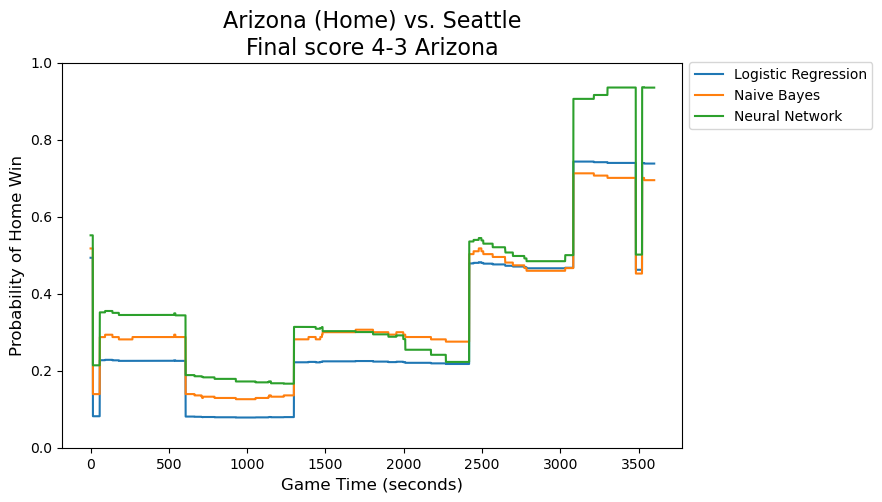

In [28]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i in range(3):
    ax.plot(np.arange(test_game_seconds.shape[0]), test_game_seconds[:, i], f'C{i}', label=model_list[i]['name'])
    ax.set_xlabel('Game Time (seconds)', fontsize=12)
    ax.set_ylabel('Probability of Home Win', fontsize=12)
    ax.set_ylim([0, 1])
    ax.set_title('Arizona (Home) vs. Seattle\nFinal score 4-3 Arizona', fontsize=16)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));
    

## Comparison of Neural Networks

Finally, as mentioned in the data exploration, the only feature that correlates with the target variable is goal differential. Therefore, it makes to check whether a simpler model, which neglects shot differential, can perform similarly.

In [35]:
data_df_goals = data_df.drop(columns='shot_diff')
# print(len(data_df_goals))
# print(len(data_df))
# print(len(shots_df))
data_df_goals.drop(shots_df[shots_df.shot_result == 'SHOT'].index, inplace=True)
data_df_goals.reset_index(drop=True, inplace=True)
display(data_df_goals.head(n=5))
# display(data_df.head(n=5))


,goal_diff,game_time,home_win
0,1,402,1
1,2,537,1
2,1,739,1
3,2,2496,1
4,1,2548,1


In [30]:
# Split the data into training and test sets
X_pd, y_pd = data_df_goals.iloc[:, :-1].values, data_df_goals.iloc[:, -1].values
tmp_split = train_test_split(X_pd, y_pd, test_size=0.25, random_state=66)
X_train, X_test, y_train, y_test = tmp_split

# Scale the data
x_scaler_goals = MinMaxScaler()
X_train_goals = x_scaler_goals.fit_transform(X_train)
X_test_goals = x_scaler_goals.transform(X_test)


In [36]:
# Define the training and test data loaders
train_data_goals = CustomDataset(X_train_goals, y_train)
test_data_goals = CustomDataset(X_test_goals, y_test)
train_dataloader_goals = DataLoader(train_data_goals, batch_size=batch_size, shuffle=False)
test_dataloader_goals = DataLoader(test_data_goals, batch_size=batch_size, shuffle=False)

# Initialize a model and optimizer
d_nn_goals = {'name': 'Neural Network (No Shots)',
              'model': Regression_NN(X_train_goals.shape[-1], 32, 1).to('cpu').float()}
# optimizer = optim.SGD(d_nn['model'].parameters(), lr=learning_rate)
optimizer = optim.Adam(d_nn_goals['model'].parameters(), lr=learning_rate)


Took 0:00:31.751837 to train the model


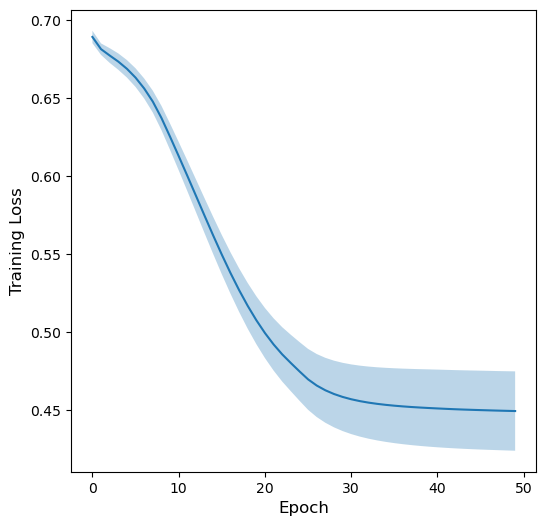

In [37]:
# Train the model
train_loss_avg = np.zeros(n_epochs)
train_loss_std = np.zeros(n_epochs)
t_start = time()
for t in range(n_epochs):
    epoch_loss = train_loop(train_dataloader_goals, d_nn_goals['model'], loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(np.arange(n_epochs), train_loss_avg)
ax.fill_between(np.arange(n_epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the model')
plt.show()


Trivial logloss for this problem: 0.688
Training logloss on NN (no shots) model: 0.449
Test logloss on NN (no shots) model: 0.439
Test accuracy on NN (no shots) model: 79.05%


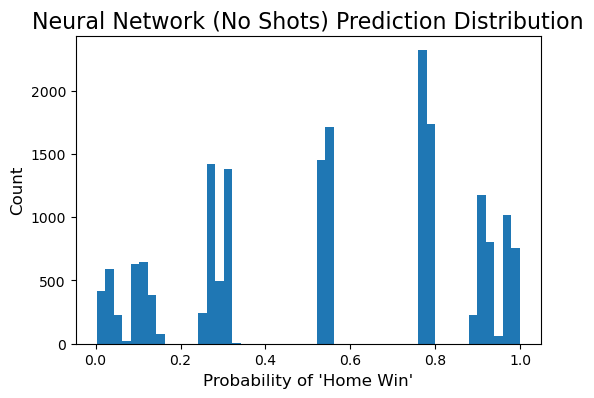

In [38]:
# Test the model
y_pred_train_nn = sigmoid(d_nn_goals['model'](Tensor(X_train_goals))).detach().numpy().squeeze()
d_nn_goals['train_loss'] = log_loss(y_train, y_pred_train_nn)
d_nn_goals['y_pred'] = sigmoid(d_nn_goals['model'](Tensor(X_test_goals))).detach().numpy().squeeze()
d_nn_goals['test_loss'] = log_loss(y_test, d_nn_goals['y_pred'])
print(f"Trivial logloss for this problem: {trivial_logloss:4.3f}")
print(f"Training logloss on NN (no shots) model: {d_nn_goals['train_loss']:4.3f}")
print(f"Test logloss on NN (no shots) model: {d_nn_goals['test_loss']:4.3f}")
pred_classes = np.round(d_nn_goals['y_pred'], 0)
d_nn_goals['test_acc'] = (pred_classes == y_test).sum() / y_test.size
print(f"Test accuracy on NN (no shots) model: {100 * d_nn_goals['test_acc']:4.2f}%")

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nn_goals['y_pred'], bins=50)
ax.set_title('Neural Network (No Shots) Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Home Win'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


IndexError: boolean index did not match indexed array along dimension 0; dimension is 17770 but corresponding boolean dimension is 202025

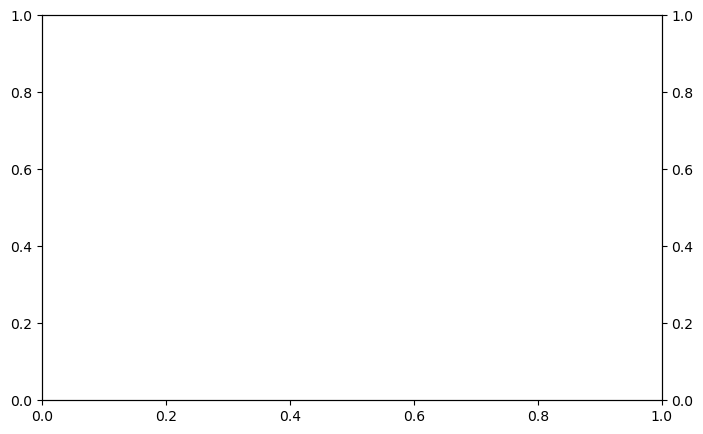

In [39]:
# Check the calibration of each model
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax2 = ax.twinx()
nn_list = [d_nn, d_nn_goals]
for i, model in enumerate(nn_list):
    # Calculate the calibration curve data
    y_pred = model['y_pred']
    counts, bins = np.histogram(y_pred, bins=10)
    mean_pred = np.zeros(bins.size - 1)
    true_frac = np.zeros(bins.size - 1)
    for j in range(bins.size - 1):
        bin_mask = (y_pred >= bins[j]) & (y_pred < bins[j + 1])
        y_pred_bin = y_pred[bin_mask]
        mean_pred[j] = np.mean(y_pred_bin)
        y_true_bin = y_test[bin_mask]
        true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size

    # Plot the calibration curve
    ax.plot(mean_pred, true_frac, c=f'C{i}', marker='s', label=model['name'])

    # Plot the prediction distributions for comparison
    xs = bins[:-1] + np.diff(bins)[0] / 2
    # ax2.bar(xs, counts, color=None, edgecolor=f'C{i}', width=1 / bins.size, alpha=0.2)
    ax2.hist(y_pred, bins=bins, color=f'C{i}', histtype='step')
    
    # Print the RMSE for each calibration curve
    weighted_rmse = np.sqrt(np.nanmean(((mean_pred - true_frac) ** 2) * counts))
    print(f"The calibration RMSE for the {model['name']} model (weighted by bin counts) is {weighted_rmse:4.3f}")
    # rmse = np.sqrt(np.nanmean((mean_pred - true_frac) ** 2))
    # print(f"The RMSE for the {model['name']} model is {rmse:4.3f}")

ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
ax.set_xlabel("Mean Predicted Probability of 'Home Wins' in Bin", fontsize=12)
ax.set_ylabel("Fraction of Actual 'Home Wins' in Bin", fontsize=12)
ax.set_title('Calibration Curves', fontsize=16)
ax.legend()
ax2.set_ylabel("Count of 'Home Wins' in Bin", fontsize=12);


In [ ]:
# Plot model predictions as a function of game time

# Extract the shot data for the test game
test_goal_df = shots_df.loc[(shots_df.game_id == test_game_id) & (shots_df.shot_result == 'GOAL')]
test_goal_list = test_shot_df[['home_score', 'away_score', 'period', 'period_time', 'shooter_home']].to_dict('records')
test_goals_norm = []
for i, shot in enumerate(test_goal_list):
    period = shot['period']
    period_time = shot['period_time']
    game_time = (period - 1) * 20 * 60 + game_time_to_sec(period_time)
    home_score = shot['home_score']
    away_score = shot['away_score']
    input_list = [home_score - away_score, game_time]
    input_arr = x_scaler_goals.transform(np.array(input_list).reshape(1, -1))
    test_goals_norm.append([input_arr, game_time])
# print(test_shots_norm)

# Calculate the home team win probability for each second of the game
test_game_seconds_goals = np.zeros((20 * 3 * 60, len(nn_list)))
for i, model in enumerate(nn_list):
    goal_cnt = 0
    goal_i = test_goals_norm[goal_cnt]
    # prev_sec = 0
    # goal_diff = 0
    # shot_diff = 0
    input_arr = x_scaler_goals.transform(np.array([0, 0]).reshape(1, -1))
    for sec in range(test_game_seconds_goals.shape[0]):
        if sec == goal_i[1]:
            goal_cnt += 1
            if goal_cnt < len(test_goals_norm):
                goal_i = test_goals_norm[goal_cnt]
                input_arr = goal_i[0]
        y_pred = sigmoid(model['model'](Tensor(input_arr))).detach().numpy().squeeze()
        test_game_seconds_goals[sec, i] = y_pred


In [ ]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i in range(3):
    ax.plot(np.arange(test_game_seconds_goals.shape[0]), test_game_seconds_goals[:, i], f'C{i}', label=nn_list[i]['name'])
    ax.set_xlabel('Game Time (seconds)', fontsize=12)
    ax.set_ylabel('Probability of Home Win', fontsize=12)
    ax.set_ylim([0, 1])
    ax.set_title('Arizona (Home) vs. Seattle\nFinal score 4-3 Arizona', fontsize=16)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));
    